In [1]:
import numpy as np
from torchtext.vocab import GloVe
import torch
from torch import nn

In [4]:
glove = GloVe(name='6B', dim=300)

In [5]:
# créer une couche d'embedding avec nn.Embedding
# importer les vecteurs déjà entraînné de GloVe dans la couche embedding
# maintenant la couche embedding comporte les vecteurs entraînnés par GloVe
embedding = nn.Embedding.from_pretrained(glove.vectors)
# afficher lal taille des poids dans la couche embeddding
print(f"embedding shape: {embedding.weight.shape}")

embedding shape: torch.Size([400000, 300])


In [6]:
words = ['man', 'woman', 'king', 'queen', 'cat', 'dog', 'mother', 'father', 'doctor', 'nurse', 'horse']
indices = []

for word in words:
    # glove.stoi permet de transformer un mot en une indice dans glove
    index = glove.stoi[word]
    indices.append(index)
    print(f"{word}: {index}")

man: 300
woman: 787
king: 691
queen: 2060
cat: 5450
dog: 2926
mother: 808
father: 629
doctor: 2082
nurse: 6794
horse: 2867


In [7]:
# transformer la liste d'indices en tensor
indices = torch.tensor(indices)
# trouver les vecteurs des indices dans glove 
vectors = embedding(indices).detach().numpy()
# affficher la taille 
print(f"vectors shape: {vectors.shape}")

vectors shape: (11, 300)


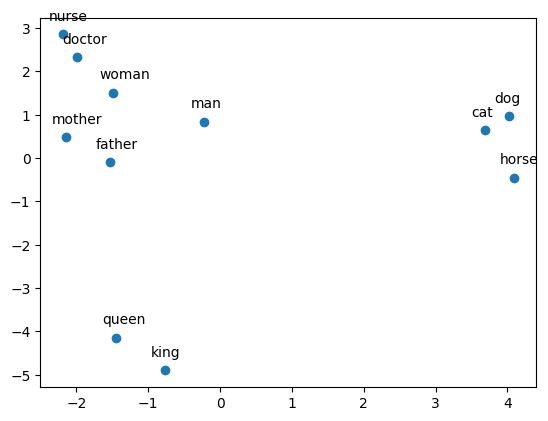

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
vectors_2D = pca.fit_transform(vectors)

plt.scatter(vectors_2D[:, 0], vectors_2D[:, 1])
for i, word in enumerate(words):
    plt.annotate(
        word,
        xy=(vectors_2D[i, 0], vectors_2D[i, 1]),
        xytext=(-10, 10),
        textcoords='offset points'
    )
    
plt.show()

In [9]:
print(vectors_2D)
print(words)

[[-0.2205956   0.83459514]
 [-1.4861952   1.5027728 ]
 [-0.7705285  -4.9031296 ]
 [-1.4510264  -4.150012  ]
 [ 3.6925733   0.64146096]
 [ 4.016278    0.96514404]
 [-2.1453943   0.4743323 ]
 [-1.5345284  -0.09405151]
 [-1.9975876   2.330584  ]
 [-2.1902325   2.8515933 ]
 [ 4.0872364  -0.4532866 ]]
['man', 'woman', 'king', 'queen', 'cat', 'dog', 'mother', 'father', 'doctor', 'nurse', 'horse']


In [10]:
# Cette fonction permet de trouver mot le plus proche que l'hypothese distributionnelle dans l'espace sémantique
def search_nearest_word(x: np.array, vector_ensemble: np.array, words: list[str]) -> str:
    minimum_distance = np.inf
    nearest_index = None
    for index_vec, vec in enumerate(vector_ensemble):
        distance = np.linalg.norm(vec - x)
        if distance < minimum_distance:
            minimum_distance = distance
            nearest_index = index_vec

    return words[nearest_index]

man = vectors_2D[words.index('man')]
woman = vectors_2D[words.index('woman')]
king = vectors_2D[words.index('king')]
queen = vectors_2D[words.index('queen')]

distribution = king - man + woman
nearest_word_1 = search_nearest_word(distribution, vectors_2D, words)
print(f"nearest word of 'king - man + woman': {nearest_word_1}")

nearest word of 'king - man + woman': queen


In [11]:
father = vectors_2D[words.index('father')]
mother = vectors_2D[words.index('mother')]

distribution_2 = father - man + woman
nearest_word_2 = search_nearest_word(distribution_2, vectors_2D, words)
print(f"nearest word of 'father - man + woman': {nearest_word_2}")

nearest word of 'father - man + woman': mother


In [12]:
doctor = vectors_2D[words.index('doctor')]
nurse = vectors_2D[words.index('nurse')]

distribution_3 = doctor - man + woman
nearest_word_3 = search_nearest_word(distribution_3, vectors_2D, words)
print(f"nearest word of 'doctor - man + woman': {nearest_word_3}")

nearest word of 'doctor - man + woman': nurse


# GloVe Algorithme

In [89]:
import numpy as np
import spacy
from scipy.spatial.distance import cosine

nlp = spacy.load("fr_core_news_sm")

corpus = [
    "The king is a man who rules a kingdom.",
    "The queen is a woman who rules a kingdom.",
    "The man is strong and wise.",
    "The woman is graceful and intelligent.",
    "The king married the queen to unite their kingdoms.",
    "A queen can reign in the absence of a king.",
    "The man aspired to be a king one day.",
    "The woman aspired to be a queen one day.",
    "Kings and queens often host grand ceremonies.",
    "The king and the queen govern the kingdom together.",
]

def build_vocab(corpus):
    vocab = set([word for sentence in corpus for word in sentence.split()])
    word_to_id = {word: idx for idx, word in enumerate(vocab)}
    id_to_word = {idx: word for idx, word in enumerate(vocab)}
    return vocab, word_to_id, id_to_word

vocab, word_to_id, id_to_word = build_vocab(corpus)
vocab_size = len(vocab)
print(word_to_id)

{'be': 0, 'in': 1, 'wise.': 2, 'who': 3, 'kingdom.': 4, 'rules': 5, 'their': 6, 'reign': 7, 'absence': 8, 'aspired': 9, 'often': 10, 'day.': 11, 'king': 12, 'king.': 13, 'govern': 14, 'kingdoms.': 15, 'can': 16, 'man': 17, 'Kings': 18, 'graceful': 19, 'married': 20, 'of': 21, 'grand': 22, 'woman': 23, 'a': 24, 'unite': 25, 'queen': 26, 'is': 27, 'strong': 28, 'and': 29, 'kingdom': 30, 'queens': 31, 'A': 32, 'one': 33, 'together.': 34, 'to': 35, 'The': 36, 'host': 37, 'ceremonies.': 38, 'intelligent.': 39, 'the': 40}


In [84]:
def build_cooccurrence_matrix(corpus, word_to_id, window_size=10):
    coocurrence_matrix = np.zeros((vocab_size, vocab_size))
    for sentence in corpus:
        words = sentence.split()
        for idx, word in enumerate(words):
            word_id = word_to_id[word]
            neighbours = words[max(idx-window_size, 0) : min(idx+window_size+1, len(words))]
            for neighbour in neighbours:
                if word != neighbour:
                    neighbour_id = word_to_id[neighbour]
                    coocurrence_matrix[word_id, neighbour_id] += 1
    return coocurrence_matrix

coocurrence_matrix = build_cooccurrence_matrix(corpus, word_to_id)
coocurrence_matrix
            

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]])

In [85]:
embedding_dim = 50
np.random.seed(42)
W = np.random.rand(vocab_size, embedding_dim)
W_context = np.random.rand(vocab_size, embedding_dim)
bias = np.random.rand(vocab_size)
bias_context = np.random.rand(vocab_size)

def glove_loss(X, W, W_context, bias, bias_context, x_max=100, alpha=0.75):
    loss = 0
    for i in range(vocab_size):
        for j in range(vocab_size):
            if X[i, j] > 0:
                weight = (X[i, j]/x_max) ** alpha if X[i, j] < x_max else 1
                J = weight * (W[i] @ W_context[j] + bias[i] + bias_context[j] - np.log(X[i, j])) ** 2
                loss += J
    loss /= vocab_size ** 2
    return loss

learning_rate = 0.01
epochs = 100
x_max = 10
alpha = 0.75

for epoch in range(epochs):
    for i in range(vocab_size):
        for j in range(vocab_size):
            if coocurrence_matrix[i, j] > 0:
                weight = (coocurrence_matrix[i, j] / x_max) ** alpha if coocurrence_matrix[i, j] < x_max else 1
                diff = W[i] @ W_context[j] + bias[i] + bias_context[j] - np.log(coocurrence_matrix[i, j])
                
                grad_W = weight * diff * W_context[j]
                grad_W_context = weight * diff * W[i]
                grad_bias = weight * diff
                grad_bias_context = weight * diff
                
                W[i] -= learning_rate * grad_W
                W_context[j] -= learning_rate * grad_W_context
                bias[i] -= learning_rate * grad_bias
                bias_context[j] -= learning_rate * grad_bias_context
            
    if epoch % 10 == 0:
        loss = glove_loss(coocurrence_matrix, W, W_context, bias, bias_context)
        print(f"epoch {epoch}, loss: {loss}")
        
word_embeddings = W + W_context


epoch 0, loss: 0.476813764647957
epoch 10, loss: 0.019373637255665092
epoch 20, loss: 0.005191220555917363
epoch 30, loss: 0.002176401810801429
epoch 40, loss: 0.0011606432861347197
epoch 50, loss: 0.0007104138338928119
epoch 60, loss: 0.0004725036748996603
epoch 70, loss: 0.00033151697602814054
epoch 80, loss: 0.00024128127712788405
epoch 90, loss: 0.00018034501921288722


In [87]:
index_king = word_to_id["king"]
index_queen = word_to_id["queen"]
index_man = word_to_id["man"]
index_woman = word_to_id["woman"]

index_aspired = word_to_id["aspired"]

vec1 = word_embeddings[index_king] - word_embeddings[index_aspired] + word_embeddings[index_woman]
vec2 = word_embeddings[index_aspired]
print(cosine(vec1, vec2))

1.4242153598634317


In [88]:
def search_analogy(word1, word2, word3, word_embeddings, word_to_id, id_to_word):
    idx_word1 = word_to_id[word1]
    idx_word2 = word_to_id[word2]
    idx_word3 = word_to_id[word3]
    
    analogy = word_embeddings[idx_word1] - word_embeddings[idx_word2] + word_embeddings[idx_word3]
    
    most_similar_value = 0
    most_similar_word = None
    for word_index, word_vector in enumerate(word_embeddings):
        cosine_sim = cosine(word_vector, analogy)
        if cosine_sim > most_similar_value:
            most_similar_value = cosine_sim
            most_similar_word = id_to_word[word_index]
    return most_similar_word
    
search_analogy('king', 'aspired', 'together.', word_embeddings, word_to_id, id_to_word)
    
    

'aspired'